In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from matplotlib import gridspec

In [4]:
tube = readsav('/Users/WilliamHenryAshfieldIV/dat/no_flare_10m.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/dat/f4_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [116]:
# set inital values
line = 1403.
mass = 28.0*1.66054e-27
kb = 1.3807e-23
c = 300
h = 6.62607e-27
flux=1.0e3 #? why this val?
ll = np.arange(line-10,line+10,0.01)

In [140]:
time = 100 # index = 0.1*time in seconds

In [141]:
# define arrays from tube.tarr
t = tube.tarr.t[time]
n = tube.tarr.n[time]
los_v = tube.tarr.v[time].T[0]
sm_v = -savgol_filter(los_v,3,1)
los_x = tube.tarr.x[time].T[0]
n_e = tube.tarr.epamu[time]*tube.tarr.rho[time]/1.67e-8 # number density
b = tube.tarr.b[time]
dl_e = tube.tarr.dl_e[time]

In [142]:
# interpolate our GofT data
te = 10**log10T
inter = interp1d(te,log10G,kind='cubic', bounds_error=False, fill_value=-10e6) #fill outide vals with large, small number
temp = 1e6*tube.tarr.t[time]
G = inter(temp)
G[temp<22000] = -10000 # set all log10G with low temp to large, small number (st 10^G~0)

In [143]:
i_min,i_max = 450,480 # subspace to interpolate over. covers entirety of condensation over time.  

In [144]:
t_s = t[i_min:i_max]
n_s = len(t_s)
los_v_s = los_v[i_min:i_max]
sm_v_s = sm_v[i_min:i_max]
los_x_s = los_x[i_min:i_max]
n_e_s = n_e[i_min:i_max]
b_s = b[i_min:i_max]
dl_e_s = dl_e[i_min:i_max]
G_s = G[i_min:i_max]
#f_nei_s = f_nei[i_min:i_max]
#f_eqi_s = f_eqi[i_min:i_max]

In [145]:
# interpolate
N=10*n_s
i_s = np.arange(0,n_s)
ii = np.arange(0,10*(n_s-1))*0.1

int_x = interp1d(i_s,los_x_s,kind='linear')#,fill_value="extrapolate")
int_v = interp1d(i_s,sm_v_s,kind='linear')
int_t = interp1d(i_s,t_s,kind='linear')
int_ne = interp1d(i_s,n_e_s,kind='linear')
int_b = interp1d(i_s,b_s,kind='linear')
int_dl_e = interp1d(i_s,dl_e_s,kind='linear')
int_G = interp1d(i_s,G_s,kind='linear')
#int_fnei = interp1d(i_s,f_nei_s,kind='linear')
#int_feqi = interp1d(i_s,f_eqi_s,kind='linear')

# new, interpolated arrays from tarr/tube
x = int_x(ii)
v = int_v(ii)
T = int_t(ii)
ne = int_ne(ii)
B = int_b(ii)
Dl = int_dl_e(ii)
g = int_G(ii)
#nei = int_fnei(ii)
#eqi = int_feqi(ii)

# factor to multiply GofT by to get actual emission given NEI
#factor = nei/eqi
#np.nan_to_num(factor, copy=False, nan=1); # replace inf values with 1 (due to zeros in eqi)

In [146]:
# process to create volume given per flux (per Maxwell)
#A = flux/B # replace by area of pixel in Mm (~0.01 Mm^2)
A_pixel = 0.029 # Mm^2 -  pixel area: 0.33 x 0.167 arcsec (as seen on sun..)

volume = Dl*A_pixel*1e24
#calcualte emission measure EM
EM=volume*ne**2

In [147]:
# calculate prefactor to turn intensity into counts
photo_erg = h*c*1e6/line*1e10 #erg/photon
pixel_size = 12.8e-3 # in ˚A [12.8 m˚A (FUV), 25.6 m˚A (NUV)]
#FOV = 0.33*175*2.35e-11 # in sr 0.33 × 175 arcsec^2 SG-slit
dim = 19e-2
A_iris = 2.2e-4 # effective area FUV
au = 1.49e11
atn = A_iris/au**2
exp_time = 4
photo_fac = pixel_size*atn*exp_time/photo_erg # converts EM*g/sig (erg/s/sr/˚A) -> photon count

In [148]:
# determine line broadening given combination of thermal, non-thermal, and instrumental broadenings
freq = c/line*1e3
v_inst = 3.9 # instrumental broadening (km/s)
sig_inst = v_inst/freq
#v_nt = 20.0 # non-thermal broadening (km/s) [De Pontieu et al, 2015] -- rough estimate for broadening 
sig_nt = v_nt/freq
sig_th = line*np.sqrt(kb*1e6*T/mass)/(c*1e6) # thermal broadening (in ˚A)
#sig = np.sqrt(sig_th**2+sig_nt**2+sig_inst**2) # total broadening
sig = np.sqrt(sig_th**2+sig_inst**2) # total broadening

# create emission array(s) for each fluid element
nn=10*(n_s-1)
emissNEI = np.empty([nn,len(ll)])
emiss = emissNEI
for i in range(nn):
    #emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
    emiss[i,:] = photo_fac*EM[i]*10**g[i]/np.sqrt(2*np.pi*sig[i])*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))

In [149]:
jjs = np.where(emiss>0)
np.unique(jjs[0])

array([140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230])

In [150]:
len(emiss)

290

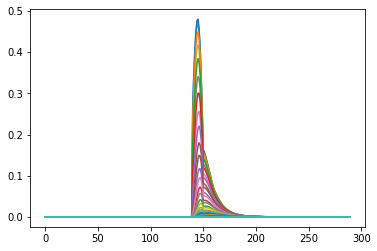

In [128]:
plt.plot(emiss);

(1402, 1405)

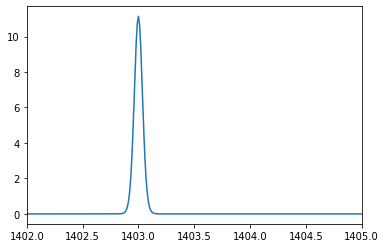

In [157]:
tot_emiss = np.sum(emiss,axis=0)
plt.plot(ll,tot_emiss)
plt.xlim(1402,1405)

In [152]:
def oneGauss(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

In [153]:
#init params
amp1 = 2
sigma1 = 0.4
cen1 = 1403

In [154]:
popt_gauss, pcov_gauss = curve_fit(oneGauss, ll, tot_emiss, p0=[amp1, cen1, sigma1])
perr_gauss = np.sqrt(np.diag(pcov_gauss))

In [155]:
print("amplitude = %0.2f (+/-) %0.2f" % (popt_gauss[0], perr_gauss[0]))
print("center = %0.2f (+/-) %0.2f" % (popt_gauss[1], perr_gauss[1]))
print("sigma = %0.2f (+/-) %0.2f" % (popt_gauss[2], perr_gauss[2]))

amplitude = 11.08 (+/-) 0.00
center = 1403.00 (+/-) 0.00
sigma = 0.04 (+/-) 0.00


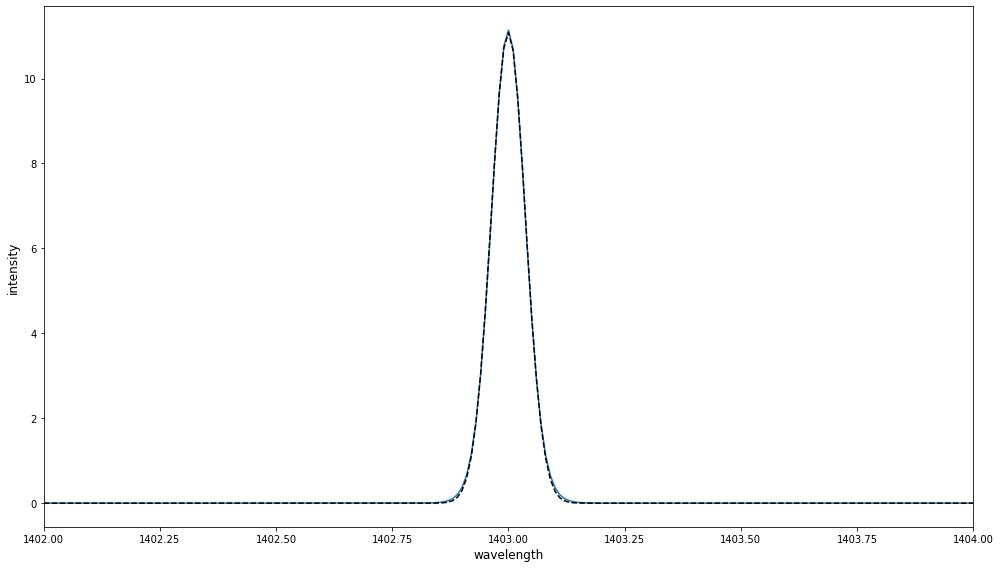

In [156]:
#plot fit
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(ll, tot_emiss)
ax1.plot(ll, oneGauss(ll, *popt_gauss), 'k--')#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))
plt.xlim(1402,1404)

ax1.set_xlabel("wavelength",  fontsize=12)
ax1.set_ylabel("intensity",  fontsize=12)
fig.tight_layout()

(-0.001, 0.003)

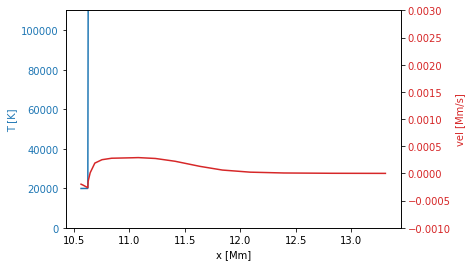

In [158]:
fig,ax = plt.subplots()

color = 'tab:blue'
ax.plot(x,T*1e6,color=color)
ax.set_ylim(0,1.1e5)
ax.set_xlabel('x [Mm]')
ax.set_ylabel('T [K]', color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()
color = 'tab:red'
ax2.plot(x, v, color=color)
ax2.set_ylabel('vel [Mm/s]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-0.001,0.003)

In [159]:
i_T=np.where((T*1e6>70000) & (T*1e6<90000))

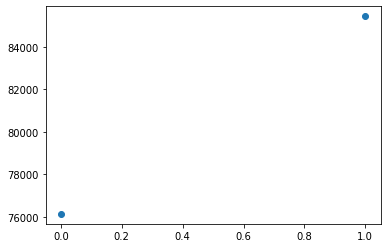

In [160]:
plt.plot(T[i_T]*1e6,'o')

In [161]:
T[i_T]*1e6

array([76132.16428363, 85454.130246  ])

In [162]:
v[i_T]*1e3

array([-0.19250924, -0.18072966])

In [164]:
line*v[i_T]/c

array([-0.0009003 , -0.00084521])

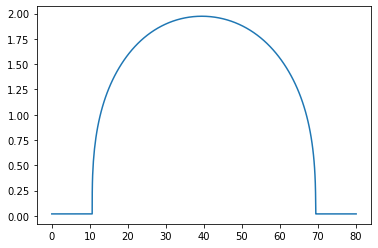

In [165]:
plt.plot(los_x,t)